In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as np
from jax import ops
from gzbuilder_analysis.fitting.optimizer import *
from gzbuilder_analysis.fitting.optimizer import _make_xy_arrays
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
subject_id = 20902006
agg_res = pd.read_pickle(f'output_files/aggregation_results/{subject_id}.pkl.gz')
fm = pd.read_pickle('lib/fitting_metadata.pkl').loc[subject_id]

In [4]:
o = Optimizer(agg_res, **fm.to_dict(), oversample_n=5)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
keys = [(k0, k1) for k0 in o.model for k1 in o.model[k0]]
p0 = pd.Series(get_p(o.model, keys), pd.MultiIndex.from_tuples(keys))

In [7]:
L_keys = (
    [('disk', 'L'), ('bulge', 'frac'), ('bar', 'frac')]
    + [('spiral', 'I.{}'.format(i)) for i in range(len(o.model['spiral']) // 6)]
)
L_keys = [i for i in L_keys if bool(o.model.get(i[0], False)) and i[1] in o.model[i[0]]]
fit_result0 = o.do_fit(options=dict(maxiter=500), keys=L_keys)

Fitting: 18it [00:13,  1.36it/s]


In [8]:
keys1 = [(k0, k1) for k0 in o.model for k1 in o.model[k0]]
p1 = get_p(fit_result0['fit_model'], keys)

In [9]:
fit_result1 = o.do_fit(keys=keys1, p0=p1, options=dict(maxiter=1000))

Fitting: 1000it [17:54,  1.07s/it]


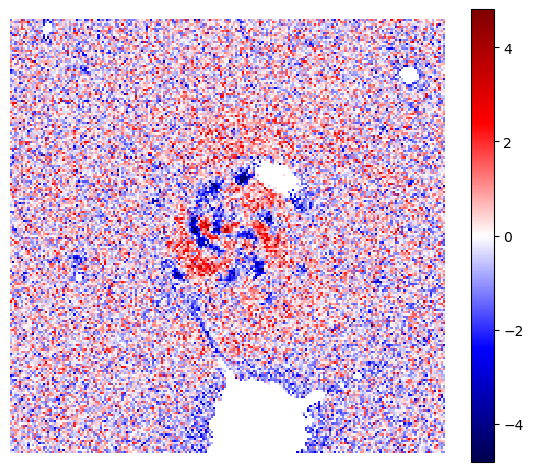

In [10]:
rg1 = o.render(fit_result1['fit_model_uncorrected'])
model1 = psf_conv(np.sum(list(rg1.values()), axis=0), o.psf)
d = ops.index_update((model1 - o.target) / o.sigma, o.mask, np.nan)
l = np.abs(np.nanmax(d))
plt.figure(figsize=(7, 6), dpi=100)
plt.imshow(d, vmin=-l, vmax=l, cmap='seismic', origin='lower')
plt.colorbar()
plt.axis('off');

In [ ]:
pd.DataFrame(fit_result1['fit_model']).unstack().dropna()

In [ ]:
from gzbuilder_analysis.fitting.optimizer import _make_render_func
from astropy.visualization import AsinhStretch
s = AsinhStretch()
rfunc = _make_render_func(fit_result1['fit_model'], o.target.shape, 5)
f, ax = plt.subplots(ncols=2, figsize=(12, 6))
kw = dict(origin='lower', cmap='gray_r')
ax[0].imshow(s(ops.index_update(o.target, o.mask, np.nan)), **kw)
ax[1].imshow(s(psf_conv(np.sum(list(rfunc(fit_result1['fit_model']).values()), axis=0), o.psf)), **kw)
[a.axis('off') for a in ax]
plt.tight_layout();